In [1]:
#Python 3.10.12
#For embedding used GloVe.6b.300d.txt
#Requirement already satisfied: pip in /usr/local/lib/python3.10/dist-packages (24.1.2)
#Collecting pip
  #Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
#Using cached pip-24.2-py3-none-any.whl (1.8 MB)
#Installing collected packages: pip
  #Attempting uninstall: pip
    #Found existing installation: pip 24.1.2
    #Uninstalling pip-24.1.2:
      #Successfully uninstalled pip-24.1.2
#Successfully installed pip-24.2

#Tensorflow Version: 2.17.0 License: Apache 2.0

In [2]:
!python3 --version

Python 3.10.12


In [3]:
!pip install --upgrade pip

  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [4]:
!pip install tensorflow

In [5]:
!pip install -U tensorflow

In [6]:
!python -m pip show tensorflow

Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [7]:
# Load, explore and plot data
import numpy as np
import pandas as pd
import re
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import string
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# Train test split
from sklearn.model_selection import train_test_split
# Text pre-processing
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# Modeling
from keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Loading data and getting sense

In [8]:
df = pd.read_csv('/content/train.csv')
df = df[['text','target']]
df.shape

(7613, 2)

In [9]:
print(len(df))
df = df.drop_duplicates('text', keep='last')
print(len(df))

7613
7503


In [10]:
df.head(10)

text  target
0  Our Deeds are the Reason of this #earthquake M...       1
1             Forest fire near La Ronge Sask. Canada       1
2  All residents asked to 'shelter in place' are ...       1
3  13,000 people receive #wildfires evacuation or...       1
4  Just got sent this photo from Ruby #Alaska as ...       1
5  #RockyFire Update => California Hwy. 20 closed...       1
6  #flood #disaster Heavy rain causes flash flood...       1
7  I'm on top of the hill and I can see a fire in...       1
8  There's an emergency evacuation happening now ...       1
9  I'm afraid that the tornado is coming to our a...       1

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7503 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7503 non-null   object
 1   target  7503 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 175.9+ KB


In [12]:
print(df.shape)

(7503, 2)


<ipython-input-13-da134a49f2cd>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette=['#3498db', '#e74c3c'])
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


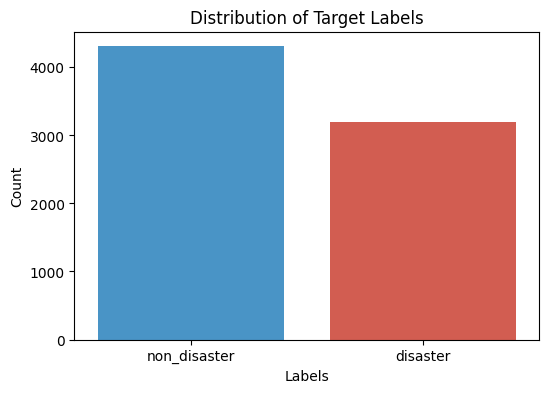

In [13]:
# Function to plot a countplot for label distribution
def label_distribution(labels):
    plt.figure(figsize=(6, 4))  # Adjust the size of the plot
    sns.countplot(x=labels, palette=['#3498db', '#e74c3c'])

    # Add labels and title
    plt.title('Distribution of Target Labels')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['non_disaster', 'disaster'])  # Rename the x-axis ticks for better understanding
    plt.show()

# Call the function to visualize label distribution using a countplot
label_distribution(df['target'])

Number of non targets:  4307
Number of targets:  3196


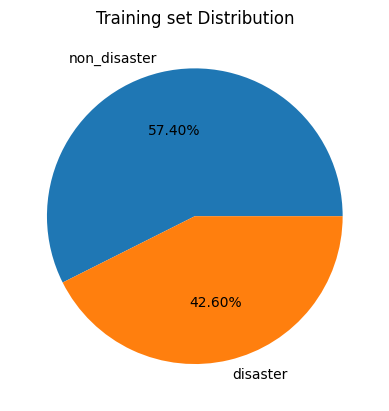

In [14]:
def label_distribution(labels):
      zero_count = 0
      one_count = 0

      for label in labels:
        if label == 0:
          zero_count += 1
        elif label == 1:
          one_count += 1

      print("Number of non targets: ", zero_count)
      print("Number of targets: ", one_count)
      plt.pie([zero_count, one_count], labels=['non_disaster', 'disaster'], autopct='%0.2f%%')
      plt.title('Training set Distribution')
      plt.show()


label_distribution(df['target'])

We can see the data set is evenly distributed. Not that much difference in the disaster and non disaster tweet in the dataset,

In [15]:
df['target'].value_counts()

target
0    4307
1    3196
Name: count, dtype: int64

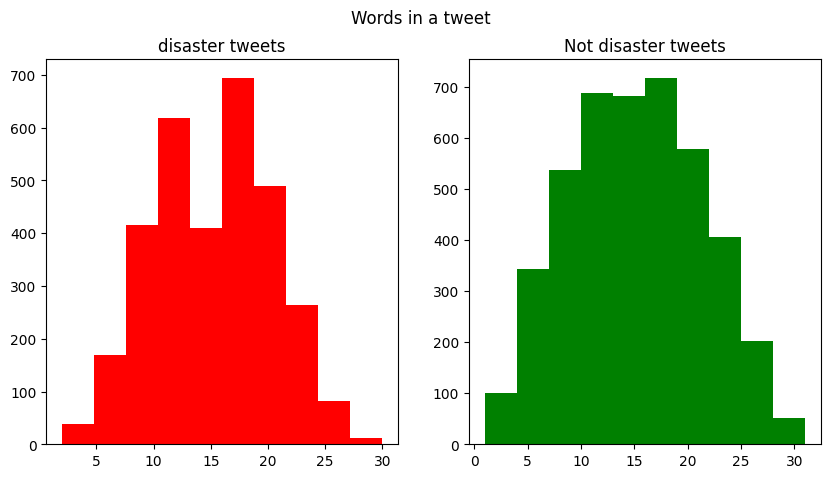

In [16]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=df[df['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=df[df['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

In [17]:
all_text = ' '.join(df[df['target']==1]['text'])

# Convert to lowercase
words = re.findall(r'\w+', all_text.lower())

# Filter out the stopwords from your word list
stop_words = set(stopwords.words("english"))
filtered_words = [word for word in words if word.lower() not in stop_words and len(word) >2]


# Count the frequency of each word
word_count = Counter(filtered_words)

# Find the top 10 most frequent words
top_10_words = word_count.most_common(50)

print(top_10_words)

analyzer = SentimentIntensityAnalyzer()
negative_word_count =0
for word in filtered_words:
    sentiment = analyzer.polarity_scores(word)
    if sentiment['compound'] < 0:
        negative_word_count += 1
print("Ratio of Negative words across all the sentences", negative_word_count/df[df['target']==1].shape[0])

[('http', 2358), ('fire', 177), ('news', 140), ('amp', 134), ('https', 132), ('via', 119), ('disaster', 116), ('california', 114), ('police', 107), ('suicide', 106), ('people', 103), ('killed', 95), ('like', 91), ('hiroshima', 91), ('storm', 89), ('crash', 85), ('fires', 85), ('families', 79), ('emergency', 77), ('nuclear', 73), ('two', 71), ('train', 71), ('attack', 71), ('bomb', 71), ('mh370', 70), ('wildfire', 69), ('buildings', 68), ('accident', 67), ('get', 66), ('one', 65), ('bombing', 65), ('video', 65), ('dead', 63), ('northern', 61), ('car', 59), ('legionnaires', 59), ('war', 57), ('homes', 57), ('burning', 56), ('still', 56), ('typhoon', 56), ('today', 55), ('new', 55), ('atomic', 55), ('japan', 55), ('bomber', 55), ('years', 53), ('obama', 53), ('forest', 51), ('2015', 51)]
Ratio of Negative words across all the sentences 1.1179599499374218


In [18]:
all_text = ' '.join(df[df['target']==0]['text'])

# Convert to lowercase
words = re.findall(r'\w+', all_text.lower())

# Filter out the stopwords from your word list
stop_words = set(stopwords.words("english"))
filtered_words = [word for word in words if word.lower() not in stop_words and len(word) >2]


# Count the frequency of each word
word_count = Counter(filtered_words)

# Find the top 10 most frequent words
top_10_words = word_count.most_common(50)

print(top_10_words)

analyzer = SentimentIntensityAnalyzer()
negative_word_count =0
for word in filtered_words:
    sentiment = analyzer.polarity_scores(word)
    if sentiment['compound'] < 0:
        negative_word_count += 1
print("Ratio of Negative words across all the sentences", negative_word_count/df[df['target']==0].shape[0])

[('http', 1917), ('https', 276), ('like', 254), ('amp', 208), ('new', 170), ('get', 163), ('one', 131), ('body', 116), ('would', 99), ('via', 98), ('video', 96), ('people', 92), ('love', 90), ('day', 86), ('know', 86), ('back', 85), ('got', 84), ('time', 83), ('full', 83), ('see', 82), ('emergency', 80), ('going', 76), ('youtube', 76), ('still', 72), ('let', 72), ('fire', 72), ('good', 67), ('man', 66), ('want', 65), ('think', 64), ('world', 63), ('lol', 62), ('life', 61), ('first', 59), ('way', 57), ('make', 56), ('news', 56), ('best', 55), ('really', 55), ('need', 55), ('burning', 55), ('reddit', 55), ('last', 54), ('work', 54), ('take', 52), ('much', 51), ('many', 51), ('help', 49), ('say', 49), ('read', 48)]
Ratio of Negative words across all the sentences 0.7766426747155792


Looks like there is a clear difference in frequency of words in disaster tweets and non disaster ones. We are seeing lot of panic words like "accident", "crash", "fires", "disaster" etc. Also ratio of negative words for disaster statement >> non-disaster statement

Data Cleaning

In [19]:
# Clear emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


# Clear html
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)


# Clear urls
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


# Clear special characters
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

def clean_df(df):
    # lower the characters
    df["text"] = df["text"].apply(lambda x: x.lower())
    df["text"] = df["text"].apply(lambda x: remove_emoji(x))
    df["text"] = df["text"].apply(lambda x: remove_html(x))
    df["text"] = df["text"].apply(lambda x: remove_URL(x))
    df["text"] = df["text"].apply(lambda x: remove_punct(x))
    # Remove multiple spaces
    df["text"] = df.text.replace("\s+", " ", regex=True)
    return df

tweet = clean_df(df)
tweet.fillna('', inplace=True)
tweet.head(10)

text  target
0  our deeds are the reason of this earthquake ma...       1
1              forest fire near la ronge sask canada       1
2  all residents asked to shelter in place are be...       1
3  13000 people receive wildfires evacuation orde...       1
4  just got sent this photo from ruby alaska as s...       1
5  rockyfire update california hwy 20 closed in b...       1
6  flood disaster heavy rain causes flash floodin...       1
7  im on top of the hill and i can see a fire in ...       1
8  theres an emergency evacuation happening now i...       1
9   im afraid that the tornado is coming to our area       1

In [20]:
# Get length column for each text
df['tweet_length'] = df['text'].apply(len)
tweet_length = df['tweet_length'].tolist()
max_length = max(tweet_length)
print("Maximum length of a tweet: ", max_length)

Maximum length of a tweet:  145


In [21]:
#train-test split
x_train, x_test, y_train, y_test = train_test_split(tweet['text'], tweet['target'], test_size=0.1, random_state=434)

In [22]:
#train-validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=434)

In [23]:
tokens = x_train.str.split()  # This will split each row of text into a list of words

# Step 2: Flatten the list of lists into a single list of words
all_words = [word for sublist in tokens for word in sublist]

# Step 3: Find the unique words
unique_words = set(all_words)

# Step 4: Get the vocabulary size
voc_size = len(unique_words)

# Print the vocabulary size
print(f"Vocabulary size: {voc_size}")

Vocabulary size: 15856


In [24]:
# Defining pre-processing parameters
max_len = max_length
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = voc_size

In [25]:
tokenizer = Tokenizer(num_words = vocab_size,char_level = False,oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)

In [26]:
# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
#total_words
print(f"Found {len(word_index)} unique tokens.")

Found 15857 unique tokens.


In [27]:
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,maxlen = max_length,padding = padding_type,truncating = trunc_type)

In [28]:
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,maxlen = max_length,padding = padding_type,truncating = trunc_type)

In [29]:
val_sequences = tokenizer.texts_to_sequences(x_val)
val_padded = pad_sequences(val_sequences,maxlen = max_length,padding = padding_type,truncating = trunc_type)

In [30]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)
print('Shape of testing tensor: ', val_padded.shape)
print(val_padded)
print(testing_padded)
print(training_padded)

Shape of training tensor:  (6076, 145)
Shape of testing tensor:  (751, 145)
Shape of testing tensor:  (676, 145)
[[   29   163    48 ...     0     0     0]
 [  600  2619     1 ...     0     0     0]
 [10167  1287  4798 ...     0     0     0]
 ...
 [  315  2802     1 ...     0     0     0]
 [  777   276   177 ...     0     0     0]
 [ 2886   239    41 ...     0     0     0]]
[[  104     1     0 ...     0     0     0]
 [13186  2723  1410 ...     0     0     0]
 [  343    19     9 ...     0     0     0]
 ...
 [13054    96    26 ...     0     0     0]
 [    1    63    11 ...     0     0     0]
 [14609   158   626 ...     0     0     0]]
[[ 637   14 1574 ...    0    0    0]
 [5762 5763   92 ...    0    0    0]
 [3840 3841 3842 ...    0    0    0]
 ...
 [ 229 5198   10 ...    0    0    0]
 [2323   44 2862 ...    0    0    0]
 [ 189  777   14 ...    0    0    0]]


Define the model architecture and train the model

In [31]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [32]:
embedding_dim = 300
embedding_matrix = create_embedding_matrix('/content/glove.6B.300d.txt',word_index, embedding_dim)
embedding_matrix.shape

(15858, 300)

In [33]:
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.04656     0.21318001 -0.0074364  ...  0.0090611  -0.20988999
   0.053913  ]
 ...
 [-0.91913998 -0.14704999 -0.16429999 ...  0.15402    -0.10571
   0.33529001]
 [ 0.032449    0.033551    0.19496    ... -0.55927002 -0.18485001
   0.25033   ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [34]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
#nonzero_elements / vocab_size
print(nonzero_elements)

11083


In [35]:
# Define a custom F1 Score metric class
from tensorflow.keras.metrics import Metric
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        prec = self.precision.result()
        rec = self.recall.result()
        f1 = 2 * ((prec * rec) / (prec + rec + K.epsilon()))
        return f1

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

Bidirectional LSTM

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers  # Import layers from tensorflow.keras
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.layers import GlobalMaxPooling1D

# Parameters
vocab_size = 15858  # Vocabulary size
embedding_dim = 300  # Dimension of the embedding
max_len = 160       # Maximum length of input sequences
drop_value = 0.2    # Dropout rate
drop_lstm = 0.2


# Define Bidirectional LSTM Model Architecture
model1= Sequential()

# Add Embedding Layer with GloVe weights
model1.add(Embedding(len(word_index) + 1,  embedding_dim, weights=[embedding_matrix], input_length=256, trainable=False))

# Add a Bidirectional LSTM layer
model1.add(Bidirectional(LSTM(128, return_sequences=False)))  # Set return_sequences=True for stacked LSTM

# Apply GlobalMaxPooling1D to reduce the output to a single vector
#model1.add(GlobalMaxPooling1D()) # This layer reduces the output from (None, sequence_length, features) to (None, features)

# Add a Dropout layer to prevent overfitting
model1.add(Dropout(drop_value))

#model1.add(Dense(64, activation='relu'))

# Add another LSTM layer for better learning (optional)
#model1.add(Bidirectional(LSTM(64)))  # Use return_sequences=False by default

# Add a Dropout layer after the LSTM
#model1.add(Dropout(drop_lstm))

# Final Dense layer with sigmoid for binary classification
model1.add(Dense(1, activation='sigmoid'))

# Build the model to ensure parameters and shapes are computed
model1.build(input_shape=(None, max_len))

# Display the model summary
model1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 160, 300)            │       4,757,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         439,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,196,953 (19.82 MB)

 Trainable params: 439,553 (1.68 MB)

 Non-trainable params: 4,757,400 (18.15 MB)

In [37]:
# Compile the model
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', F1Score()])

In [38]:
num_epochs = 20
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model1.fit(training_padded,y_train,epochs=num_epochs, batch_size=25, validation_data=(val_padded, y_val),callbacks =[early_stop],verbose=2)

Epoch 1/20
244/244 - 126s - 518ms/step - accuracy: 0.7781 - f1_score: 0.7167 - loss: 0.4819 - val_accuracy: 0.8195 - val_f1_score: 0.7500 - val_loss: 0.4306
Epoch 2/20
244/244 - 140s - 573ms/step - accuracy: 0.8214 - f1_score: 0.7759 - loss: 0.4097 - val_accuracy: 0.8314 - val_f1_score: 0.7808 - val_loss: 0.4173
Epoch 3/20
244/244 - 142s - 581ms/step - accuracy: 0.8389 - f1_score: 0.7971 - loss: 0.3755 - val_accuracy: 0.8254 - val_f1_score: 0.7659 - val_loss: 0.4164
Epoch 4/20
244/244 - 143s - 585ms/step - accuracy: 0.8540 - f1_score: 0.8181 - loss: 0.3530 - val_accuracy: 0.8077 - val_f1_score: 0.7751 - val_loss: 0.4762
Epoch 5/20
244/244 - 145s - 596ms/step - accuracy: 0.8749 - f1_score: 0.8451 - loss: 0.3050 - val_accuracy: 0.8077 - val_f1_score: 0.7566 - val_loss: 0.5035
Epoch 6/20
244/244 - 119s - 489ms/step - accuracy: 0.8853 - f1_score: 0.8570 - loss: 0.2872 - val_accuracy: 0.7944 - val_f1_score: 0.7486 - val_loss: 0.5014


In [39]:
train_loss, training_accuracy,training_f1 = model1.evaluate(training_padded, y_train)
print(f'Training Accuracy: {training_accuracy* 100:.2f}%')
print(f'Training F1_Score: {training_f1* 100:.2f}%')

190/190 ━━━━━━━━━━━━━━━━━━━━ 36s 191ms/step - accuracy: 0.8685 - f1_score: 0.8326 - loss: 0.3347
Training Accuracy: 86.64%
Training F1_Score: 82.91%


In [40]:
test_loss, testing_accuracy, testing_f1 = model1.evaluate(testing_padded, y_test)
print(f"Test Accuracy: {testing_accuracy * 100:.2f}%")

print(f'Testing F1_Score: {testing_f1 * 100:.2f}%')

24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 235ms/step - accuracy: 0.7992 - f1_score: 0.7605 - loss: 0.4297
Test Accuracy: 80.69%
Testing F1_Score: 76.65%


24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 371ms/step


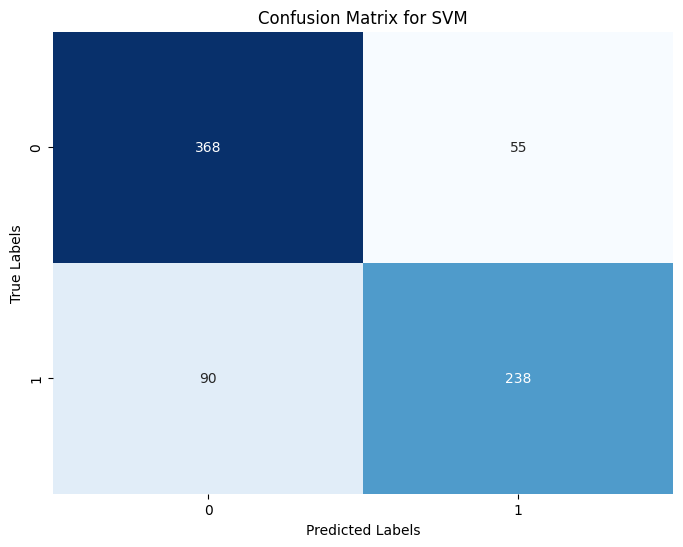

In [41]:
import sys
from sklearn.metrics import confusion_matrix
# Model Performance
y_pred = model1.predict(testing_padded)
y_pred_classes = (y_pred > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for SVM')
plt.show()


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step


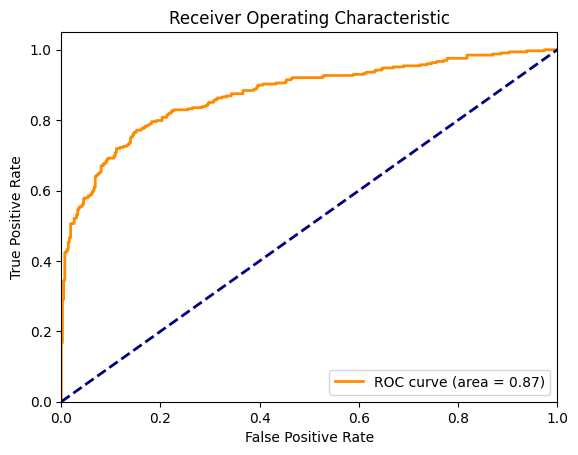

In [42]:
from sklearn.metrics import roc_curve, auc

# Compute predicted probabilities
y_pred_proba = model1.predict(testing_padded)
y_pred = (y_pred_proba > 0.5).astype("int32")

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [43]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score
y_pred_proba = model1.predict(testing_padded)
y_pred = (y_pred_proba > 0.5).astype("int32")

# Precision score (binary classification)
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.2f}')



# Recall score (binary classification)
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.2f}')

# F1 score (binary classification)
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.2f}')

# ROC-AUC Score
y_pred_proba = model1.predict(testing_padded)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC Score: {roc_auc:.2f}')

# Classification Report for detailed performance
print(classification_report(y_test, y_pred, target_names=['non_disaster', 'disaster']))

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step
Precision: 0.81
Recall: 0.73
F1 Score: 0.77
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step
AUC Score: 0.87
              precision    recall  f1-score   support

non_disaster       0.80      0.87      0.84       423
    disaster       0.81      0.73      0.77       328

    accuracy                           0.81       751
   macro avg       0.81      0.80      0.80       751
weighted avg       0.81      0.81      0.81       751



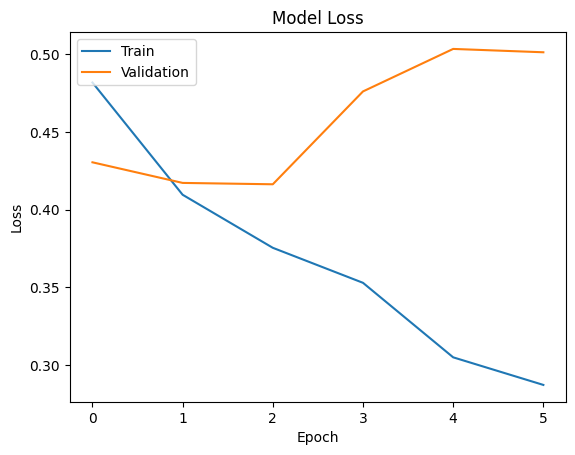

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

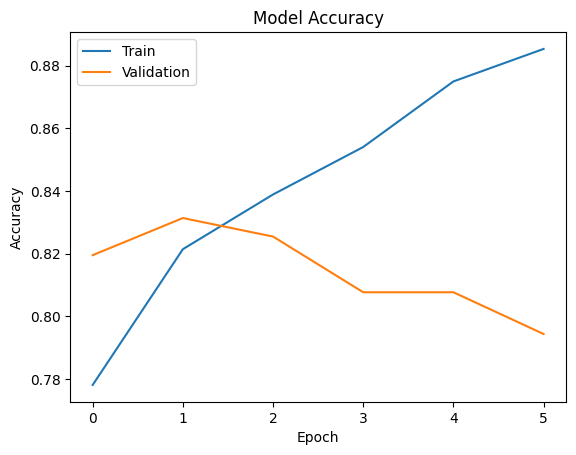

In [45]:
#`history` is the result of model.fit
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()